### Annotating Data: leveraging foundation models to prepare your data

*   Segment Anything in Images and Videos
*   Lhama
*   Florence
*   Sapiens: Foundation for Human Vision Models


What is a foundation model?



> A foundation model is any model that is trained on broad data (generally using self-supervision at scale) that can be adapted (e.g., fine-tuned) to a wide range of downstream tasks - On the Opportunities and Risks of
Foundation Models, Stanford Institute.


![Alt Text](https://blogs.nvidia.com/wp-content/uploads/2023/03/Transformer-apps.jpg)



#### Segment Anything in Images and Videos
Segmentation dataset to date (by far), with over 1 billion masks on 11M licensed and privacy respecting images

![Alt Text](https://cdn.prod.website-files.com/5d7b77b063a9066d83e1209c/6540eae63ebdce4c1ab08c93_Segment%20Anything%20Model.webp)



In [1]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy


import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.9 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-e7yp39fs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-e7yp39fs
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp310-linux

In [2]:
!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

--2024-10-17 02:34:20--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_large.pt’

sam2.1_hiera_large. 100%[===================>] 856.48M   153MB/s    in 5.1s    

2024-10-17 02:34:25 (166 MB/s) - ‘../checkpoints/sam2.1_hiera_large.pt’ saved [898083611/898083611]



In [3]:
#Adapted from: https://github.com/facebookresearch/sam2/tree/main/notebooks

import os
import torch
import torchvision
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
from natsort import natsorted
import cv2
import mediapy as media

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [4]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True


In [5]:
np.random.seed(3)

def show_mask_video(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_box_v2(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2], box[3]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [6]:
url = "https://github.com/wallaceloos/Image_Processing/blob/master/images/apple_leftover_2600.png?raw=true"
file_name = "input.png"

!wget -q -O $file_name $url

image = Image.open(file_name)
image = np.array(image.convert("RGB"))


#### **Automatic**

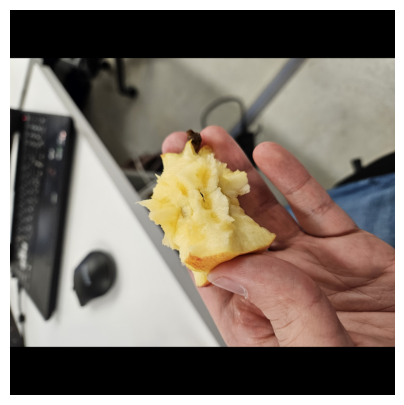

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [9]:
masks = mask_generator.generate(image)

In [10]:
print(len(masks)) #number of masks
print(masks[0].keys())

33
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
#Predicted iou: denote the confidence score SAM has for each predicted mask to be “correct
print('Area:', masks[0]['area'], 'Predicted iou:', "{:.2f}".format(masks[0]['predicted_iou']), 'Stability score:', "{:.2f}".format(masks[0]['stability_score']))

Area: 71404 Predicted iou: 0.99 Stability score: 0.98


In [12]:
input_point = np.asarray(masks[0]['point_coords'])
input_bb = np.asarray(masks[0]['bbox'])
input_label = np.array([1])

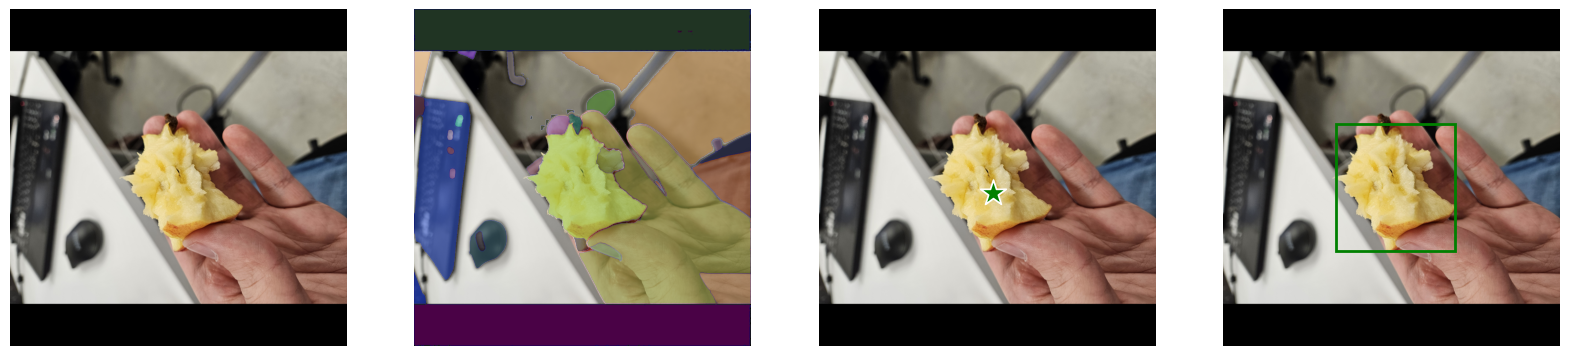

In [13]:
plt.figure(figsize=(20, 20))
plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(image)
show_box_v2(input_bb, plt.gca())
plt.axis('off')
plt.show()

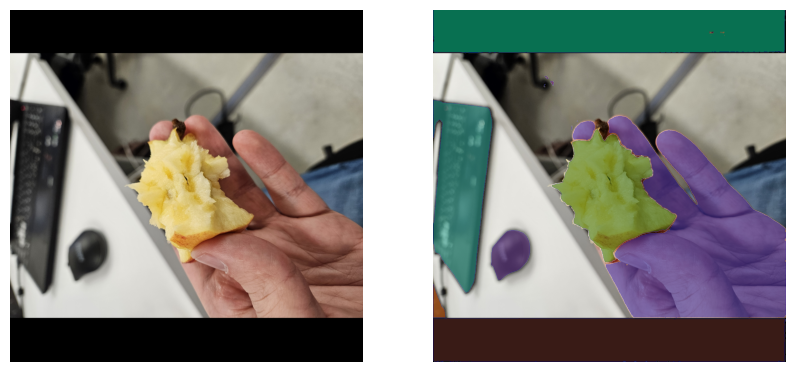

In [14]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    pred_iou_thresh=0.97,
    stability_score_thresh=0.97
)

masks2 = mask_generator_2.generate(image)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

#### **Prompt**

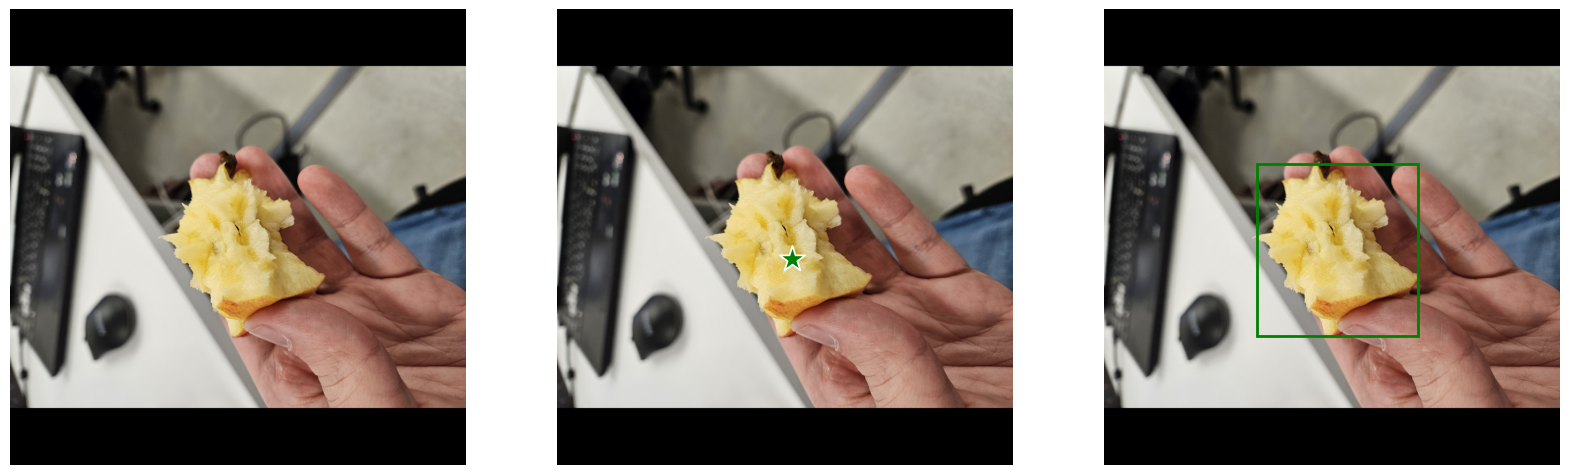

In [15]:
input_bb_v2 = np.array([344, 348, 705, 734])

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(image)
show_box(input_bb_v2, plt.gca())
plt.axis('off')
plt.show()

In [16]:
predictor = SAM2ImagePredictor(sam2)
predictor.set_image(image)

In [17]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_bb_v2[None, :],
    multimask_output=False,
)

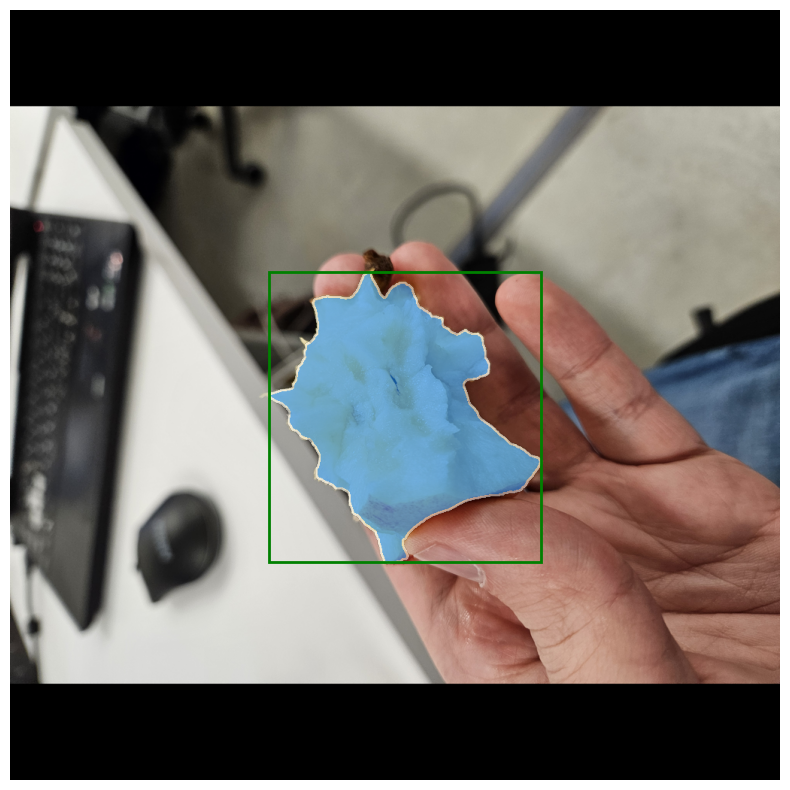

In [18]:
show_masks(image, masks, scores, box_coords=input_bb_v2)

##### **Video**

In [19]:
!mkdir -p videos
!wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
!unzip -d videos videos/bedroom.zip

--2024-10-17 02:38:53--  https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.71, 13.35.238.113, 13.35.238.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12688166 (12M) [application/zip]
Saving to: ‘videos/bedroom.zip’

bedroom.zip         100%[===================>]  12.10M  --.-KB/s    in 0.05s   

2024-10-17 02:38:53 (263 MB/s) - ‘videos/bedroom.zip’ saved [12688166/12688166]

Archive:  videos/bedroom.zip
   creating: videos/bedroom/
  inflating: videos/bedroom/00005.jpg  
  inflating: videos/bedroom/00121.jpg  
  inflating: videos/bedroom/00079.jpg  
  inflating: videos/bedroom/00126.jpg  
  inflating: videos/bedroom/00002.jpg  
  inflating: videos/bedroom/00128.jpg  
  inflating: videos/bedroom/00070.jpg  
  inflating: videos/bedroom/00185.jpg  
  inflating: videos/bedroom/00154.jpg  
  i

In [20]:
predictor_video = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

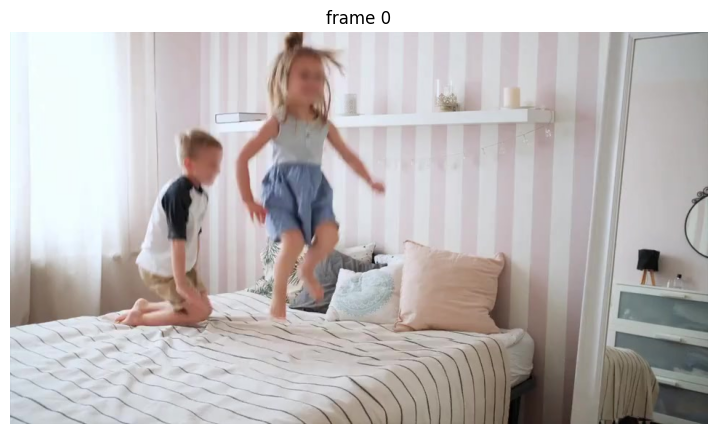

In [21]:
# video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.axis('off')
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.show()

In [22]:
#SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video.
#During initialization, it loads all the JPEG frames

inference_state = predictor_video.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 200/200 [00:06<00:00, 31.18it/s]


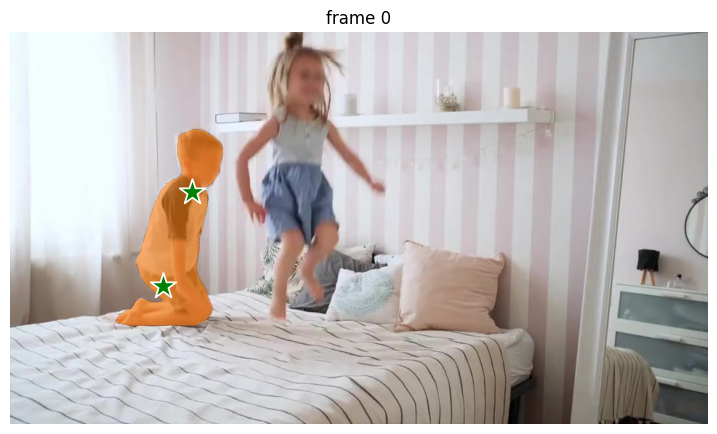

In [23]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[210, 350], [250, 220]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor_video.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask_video((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
plt.axis('off')
plt.show()

propagate in video: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


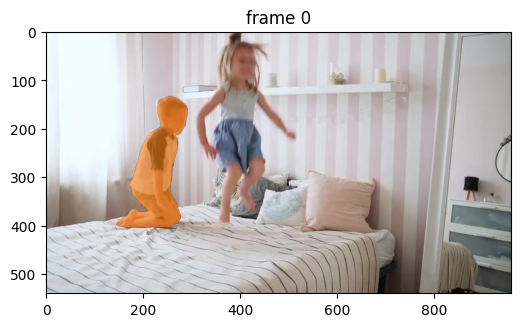

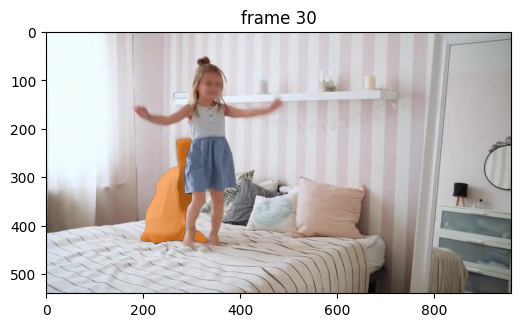

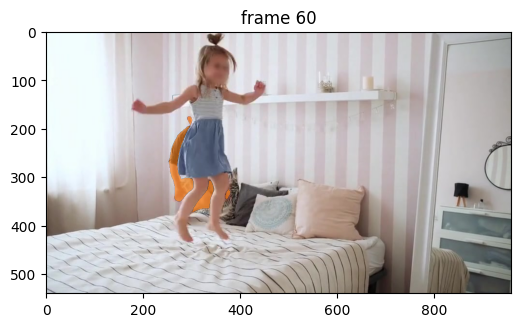

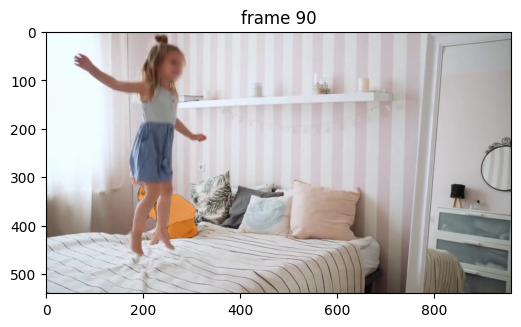

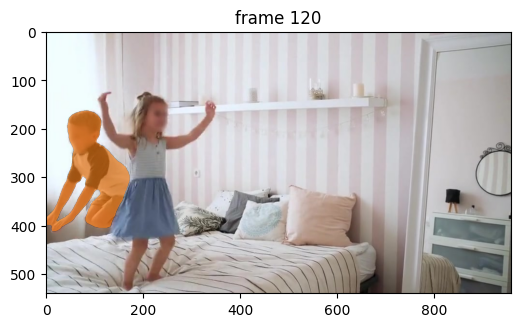

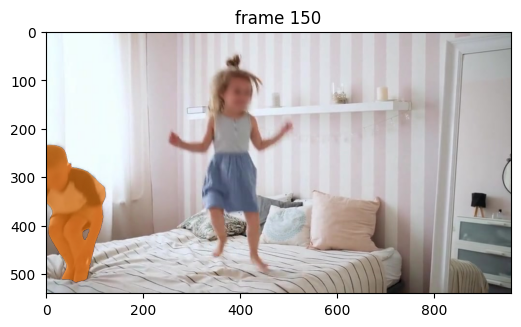

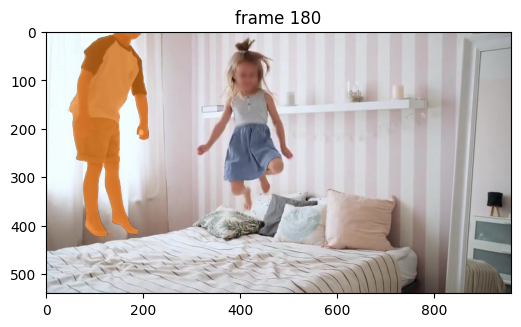

In [24]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor_video.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask_video(out_mask, plt.gca(), obj_id=out_obj_id)

In [25]:
!mkdir -p ../video_seg_result/

for out_frame_idx in range(0, len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        plt.axis('off')
        show_mask_video(out_mask, plt.gca(), obj_id=out_obj_id)
    plt.savefig(f"../video_seg_result/frame_{out_frame_idx}.png")
    plt.close()

In [26]:
frame_names_results = [
    p for p in os.listdir('/video_seg_result/')
    if os.path.splitext(p)[-1] in [".png"]
]

image_folder = '../video_seg_result/'
frame_names_results = natsorted(frame_names_results)
frame = cv2.imread(os.path.join(image_folder, frame_names_results[0]))
height, width, layers = frame.shape
video_name = "../video_seg_result.mp4"
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 30, (width,height))

for image in frame_names_results:
    video.write(cv2.imread(os.path.join(image_folder, image)))
video.release()

In [27]:
video_play = media.read_video(video_name)
media.show_video(video_play, fps=30, codec='h264')

#### **Lhama**

In [28]:
#Adapated from: https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0

import torch
from transformers import pipeline

In [29]:
pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16, device_map="auto")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [30]:
messages = [
    {"role": "user", "content": "Where Calgary is located?"},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=100, do_sample=True, temperature=0.7, top_k=50, top_p=0.95 )
print(outputs[0]["generated_text"])

<|user|>
Where Calgary is located?</s>
<|assistant|>
Calgary is located in the province of Alberta, Canada. It is Canada's second-largest city, after Toronto, and is located in the western part of the province.


https://huggingface.co/spaces/huggingface-projects/llama-3.2-vision-11B  
https://huggingface.co/OpenGVLab/InternVL2-1B

#### **Florence**

Dataset called FLD-5B, encompassing a total of 5.4B annotations for 126M images

![Alt Text](https://images.prismic.io/encord/9bb8ae77-7b87-4196-ae81-4cf9a6da8a83_image1.png?auto=compress,format)

In [31]:
#Adapated from: https://huggingface.co/microsoft/Florence-2-large
!pip install flash_attn timm
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.4 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [32]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

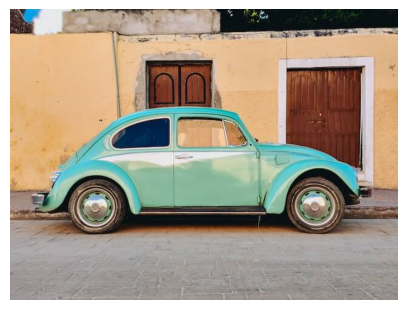

In [33]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
image = np.array(image.convert("RGB"))

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [34]:
#prompt = "<CAPTION>"
#prompt = "<REGION_PROPOSAL>"
#prompt = "<OCR>"
prompt = "<OD>"

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.shape[1], image.shape[0]))

print(parsed_answer)

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [450.8800048828125, 276.7200012207031, 554.5599975585938, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.72000122070312, 371.2799987792969]], 'labels': ['car', 'door', 'wheel', 'wheel']}}


In [35]:
print(parsed_answer['<OD>']['labels'])

['car', 'door', 'wheel', 'wheel']


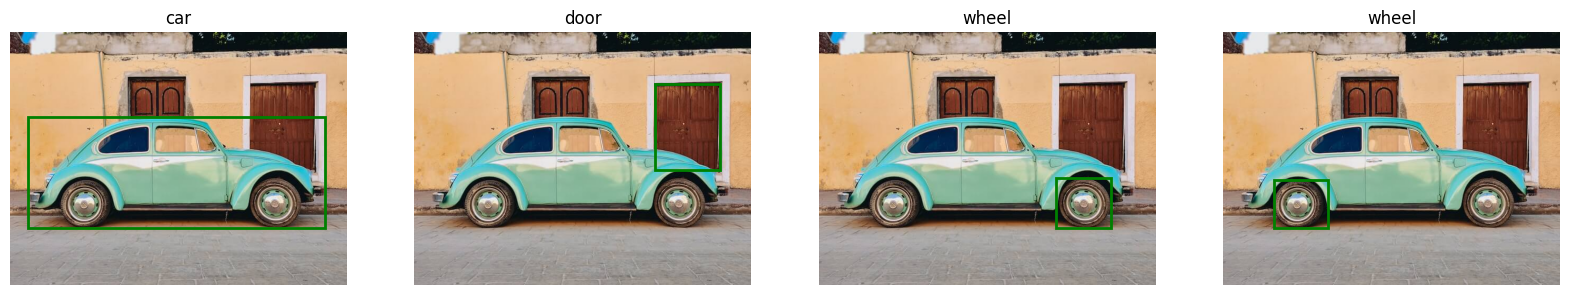

In [36]:
parsed_answer['<OD>']['bboxes'][0]
plt.figure(figsize=(20, 20))
plt.subplot(1,4,1)
plt.title(parsed_answer['<OD>']['labels'][0])
plt.imshow(image)
show_box(parsed_answer['<OD>']['bboxes'][0], plt.gca())
plt.axis('off')
plt.subplot(1,4,2)
plt.title(parsed_answer['<OD>']['labels'][1])
plt.imshow(image)
show_box(parsed_answer['<OD>']['bboxes'][1], plt.gca())
plt.axis('off')
plt.subplot(1,4,3)
plt.title(parsed_answer['<OD>']['labels'][2])
plt.imshow(image)
show_box(parsed_answer['<OD>']['bboxes'][2], plt.gca())
plt.axis('off')
plt.subplot(1,4,4)
plt.title(parsed_answer['<OD>']['labels'][3])
plt.imshow(image)
show_box(parsed_answer['<OD>']['bboxes'][3], plt.gca())
plt.axis('off')
plt.show()

In [37]:
prompt = "<CAPTION>"
#prompt = "<REGION_PROPOSAL>"
#prompt = "<OCR>"
#prompt = "<OD>"

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.shape[1], image.shape[0]))

print(parsed_answer)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}


In [38]:
image = Image.open("input.png")
image = np.array(image.convert("RGB"))

#prompt = "<CAPTION>"
#prompt = "<REGION_PROPOSAL>"
#prompt = "<OCR>"
prompt = "<OD>"

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.shape[1], image.shape[0]))

print(parsed_answer)

{'<OD>': {'bboxes': [[336.3840026855469, 340.4800109863281, 712.1920166015625, 737.7920532226562], [400.8960266113281, 306.6880187988281, 1022.4640502929688, 899.5840454101562]], 'labels': ['apple', 'human hand']}}


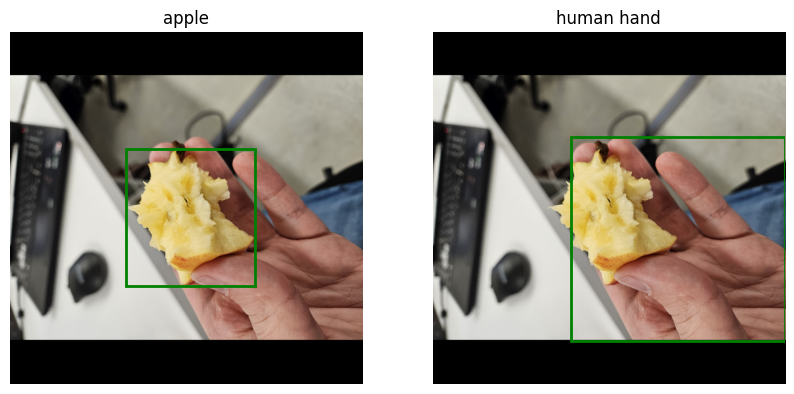

In [39]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.title(parsed_answer['<OD>']['labels'][0])
plt.imshow(image)
show_box(parsed_answer['<OD>']['bboxes'][0], plt.gca())
plt.axis('off')
plt.subplot(1,2,2)
plt.title(parsed_answer['<OD>']['labels'][1])
plt.imshow(image)
show_box(parsed_answer['<OD>']['bboxes'][1], plt.gca())
plt.axis('off')
plt.show()

In [40]:
prompt = "<CAPTION>"
#prompt = "<OCR>"
#prompt = "<OD>"

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.shape[1], image.shape[0]))

print(parsed_answer)

{'<CAPTION>': 'A person holding a piece of fruit in their hand.'}


#### **Sapiens**

https://github.com/facebookresearch/sapiens   
https://huggingface.co/spaces/facebook/sapiens-pose